# Titanic

The dataset is from a competition in kaggle at https://www.kaggle.com/c/titanic.

The goal is to predict which passengers suvived in the Titanic sjipwreck.

A part of code in this project refers to some codes in the competition.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import csv
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
# set a random seed for reporducibility
myseed = 666
np.random.seed(myseed)
torch.manual_seed(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [4]:
# path to the training/test data
train_path = 'data/train.csv'
test_path = 'data/train.csv'

# read the data
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [5]:
df_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
print('Trained data missing values:\n')
print(df_train.isnull().sum())
print('\n','-'*40, '\n')
print('Test data missing values:\n')
print(df_test.isnull().sum())

Trained data missing values:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

 ---------------------------------------- 

Test data missing values:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [9]:
# transfer categorical features into number
sex    = pd.get_dummies(df_train['Sex'],drop_first=True)
embark = pd.get_dummies(df_train['Embarked'],drop_first=True)

In [10]:
sex

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [11]:
embark

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
886,0,1
887,0,1
888,0,1
889,0,0


In [12]:
df_train = pd.concat([df_train,sex,embark],axis=1)
df_test  = pd.concat([df_test ,sex,embark],axis=1)

In [13]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1,0,0


In [14]:
df_train.drop(['Sex','Embarked', 'Name', 'Ticket', 'Cabin'],axis=1,inplace=True)
df_test.drop(['Sex','Embarked', 'Name', 'Ticket', 'Cabin'],axis=1,inplace=True)

df_train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,1,0,1
887,888,1,1,19.0,0,0,30.0000,0,0,1
888,889,0,3,NaN,1,2,23.4500,0,0,1
889,890,1,1,26.0,0,0,30.0000,1,0,0


In [15]:
import seaborn as sns

<AxesSubplot:>

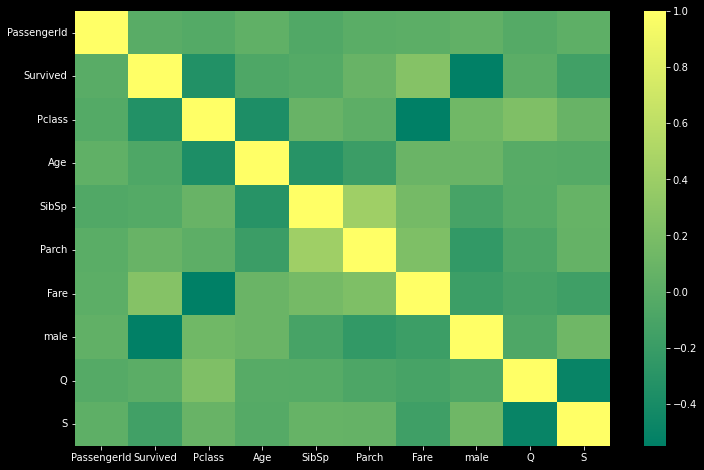

In [16]:
fig_dim = (12, 8)
fig, ax = plt.subplots(figsize=fig_dim)
sns.heatmap(df_train.corr(), cmap='summer')

In [17]:
abs(df_train.corr()["Survived"])

PassengerId    0.005007
Survived       1.000000
Pclass         0.338481
Age            0.077221
SibSp          0.035322
Parch          0.081629
Fare           0.257307
male           0.543351
Q              0.003650
S              0.155660
Name: Survived, dtype: float64

In [18]:
from sklearn.pipeline      import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute        import SimpleImputer
from sklearn.linear_model  import LogisticRegression

In [19]:
imputer  = SimpleImputer()
scaler   = StandardScaler()
clf      = LogisticRegression()
pipe     = make_pipeline(imputer,scaler,clf)

In [23]:
print(df_test.isnull().sum())
df_test.fillna(df_test.mean(), inplace=True) # replace the nan value by mean
print('-' * 40)
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Age            177
SibSp            0
Parch            0
Fare             0
male             0
Q                0
S                0
dtype: int64
----------------------------------------
PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
male           0
Q              0
S              0
dtype: int64


In [24]:
features = df_train.drop('Survived',axis=1).columns

X,y   = df_train[features], df_train['Survived']

In [25]:
X

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,3,22.0,1,0,7.2500,1,0,1
1,2,1,38.0,1,0,71.2833,0,0,0
2,3,3,26.0,0,0,7.9250,0,0,1
3,4,1,35.0,1,0,53.1000,0,0,1
4,5,3,35.0,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...
886,887,2,27.0,0,0,13.0000,1,0,1
887,888,1,19.0,0,0,30.0000,0,0,1
888,889,3,NaN,1,2,23.4500,0,0,1
889,890,1,26.0,0,0,30.0000,1,0,0


In [26]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [27]:
pipe.fit(X,y)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [29]:
df_test.drop('Survived',axis=1, inplace=True)
df_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,3,22.000000,1,0,7.2500,1,0,1
1,2,1,38.000000,1,0,71.2833,0,0,0
2,3,3,26.000000,0,0,7.9250,0,0,1
3,4,1,35.000000,1,0,53.1000,0,0,1
4,5,3,35.000000,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...
886,887,2,27.000000,0,0,13.0000,1,0,1
887,888,1,19.000000,0,0,30.0000,0,0,1
888,889,3,29.699118,1,2,23.4500,0,0,1
889,890,1,26.000000,0,0,30.0000,1,0,0


In [30]:
y_pred = pd.DataFrame(pipe.predict(df_test))

In [31]:
y_pred

,0
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [32]:
y_pred['Survived'] = y_pred[0]
y_pred

,0,Survived
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0
...,...,...
886,0,0
887,1,1
888,0,0
889,1,1


In [33]:
y_pred.drop(0,axis=1,inplace=True)
y_pred

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [34]:
y_pred['PassengerId'] = df_test['PassengerId']
y_pred

,Survived,PassengerId
0,0,1
1,1,2
2,1,3
3,1,4
4,0,5
...,...,...
886,0,887
887,1,888
888,0,889
889,1,890


In [35]:
y_pred.to_csv('titanic_pred_logistic.csv',index=False)